In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import numba
from numba import njit,jit
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [3]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 2.71 s


In [4]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0))
By = np.transpose(a.twbox[0].by,(2,1,0))
Bz = np.transpose(a.twbox[0].bz,(2,1,0))

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

time: 2.02 ms


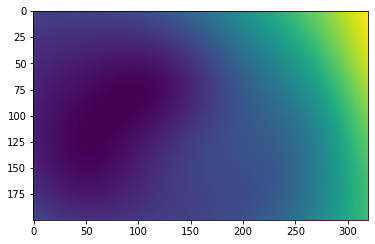

time: 211 ms


In [5]:
plt.imshow(Bz[350:670,200:400,100].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)

In [6]:
np.mean(np.abs((Bx)))

11.779769

time: 1.27 s


In [7]:
vec = np.array([1.01,2.01,5.01])
vec[vec<=0]=1e-9
vec[vec>=Bx.shape]=(np.array(Bx.shape)-1e-9)[vec>=Bx.shape]

time: 970 µs


In [8]:
Bx_gpu.shape

(0,)

time: 2.98 ms


In [267]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBline.cu", "rt")
traceFunc =SourceModule(traceFunc_file.read(), include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = traceFunc.get_function("TraceAllBline")
print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = gpuarray.to_gpu(Bx.astype(np.float32))
    By_gpu = gpuarray.to_gpu(By.astype(np.float32))
    Bz_gpu = gpuarray.to_gpu(Bz.astype(np.float32))

compiling kernel
kernel compiled
time: 11.4 s


<ipython-input-267-0c570a84d529>:10: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(201): warning: variable "res" was set but never used

kernel.cu(212): warning: variable "P_b" was set but never used

kernel.cu

  traceFunc =SourceModule(traceFunc_file.read(), include_dirs=[PWD], cache_dir='cache',no_extern_c=True)


In [268]:
# shape of B
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape

interp_ratio=4
x_range = [0,1163]
y_range = [0,487]
x_range = [350,670]
y_range = [200,400]
#x_range = [450,550]
#y_range = [280,350]
#x_range = [587,588]
#y_range = [301,302]
x_i = np.linspace(*x_range, np.uint32(interp_ratio*(x_range[1]-x_range[0])))
y_i = np.linspace(*y_range, np.uint32(interp_ratio*(y_range[1]-y_range[0])))
x_arr,y_arr = np.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten().astype(np.float32)
y_inp = y_arr.flatten().astype(np.float32)
z_inp = np.zeros_like(x_inp).astype(np.float32)

#z_inp[:] = 23.0

x_out = np.zeros_like(x_inp).astype(np.float32)
y_out = np.zeros_like(x_inp).astype(np.float32)
z_out = np.zeros_like(x_inp).astype(np.float32)

Bx_out = np.zeros_like(x_inp).astype(np.float32)
By_out = np.zeros_like(x_inp).astype(np.float32)
Bz_out = np.zeros_like(x_inp).astype(np.float32)

Bx_inp = np.zeros_like(x_inp).astype(np.float32)
By_inp = np.zeros_like(x_inp).astype(np.float32)
Bz_inp = np.zeros_like(x_inp).astype(np.float32)

flag_out = np.zeros_like(x_inp).astype(np.int32)
step_line_len = np.zeros_like(x_inp).astype(np.ulonglong)

s_len = np.float32([1./16.])
N=np.ulonglong([x_inp.shape[0]])

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)

# chuck everything

time: 121 ms


In [269]:
y_arr.shape

(800, 1280)

time: 2 ms


In [270]:
BshapeN

array([1164,  488,  488])

time: 2 ms


In [271]:
BshapeN = gpuarray.to_gpu(BshapeN)
x_inp = gpuarray.to_gpu(x_inp)
y_inp = gpuarray.to_gpu(y_inp)
z_inp = gpuarray.to_gpu(z_inp)

x_out = gpuarray.to_gpu(x_out)
y_out = gpuarray.to_gpu(y_out)
z_out = gpuarray.to_gpu(z_out)

s_len    = gpuarray.to_gpu(s_len)
flag_out = gpuarray.to_gpu(flag_out)
N        = gpuarray.to_gpu(N)


Bx_out = gpuarray.to_gpu(Bx_out)
By_out = gpuarray.to_gpu(By_out)
Bz_out = gpuarray.to_gpu(Bz_out)

Bx_inp = gpuarray.to_gpu(Bx_inp)
By_inp = gpuarray.to_gpu(By_inp)
Bz_inp = gpuarray.to_gpu(Bz_inp)

step_line_len = gpuarray.to_gpu(step_line_len)


time: 41 ms


In [272]:
TraceAllBline(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
             x_inp,y_inp,z_inp,
             x_out,y_out,z_out,
             s_len,
             Bx_inp,By_inp,Bz_inp,
             Bx_out,By_out,Bz_out,
             flag_out,N,step_line_len,
             block=blck,grid=grd)

pycuda.driver.Context.synchronize()

time: 201 ms


In [ ]:
x_end_arr = x_out.get().reshape(xy_shape).astype(np.float64)
y_end_arr = y_out.get().reshape(xy_shape).astype(np.float64)
flags_arr = flag_out.get().reshape(xy_shape).astype(np.float64)
Bz_arr_in = Bz_inp.get().reshape(xy_shape).astype(np.float64)
Bz_arr_out = Bz_out.get().reshape(xy_shape).astype(np.float64)
a = (x_end_arr[2:,1:-1]-x_end_arr[0:-2,1:-1])/2
b = (x_end_arr[1:-1,2:]-x_end_arr[1:-1,0:-2])/2
c = (y_end_arr[2:,1:-1]-y_end_arr[0:-2,1:-1])/2
d = (y_end_arr[1:-1,2:]-y_end_arr[1:-1,0:-2])/2


Q = (a**2+b**2+c**2+d**2)/np.abs(Bz_arr_in[1:-1,1:-1]/Bz_arr_out[1:-1,1:-1])*(interp_ratio**2)
Q[np.where(Q<1.0)]=1.0


In [ ]:
plt.close()

xxlim=None
yylim=None

fig=plt.figure(0,dpi=120); ax = plt.gca() 
img=ax.imshow(flag_out.get().reshape(xy_shape),cmap='inferno',origin='lower',vmin=0)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=120); ax = plt.gca() 
img=ax.imshow(line_len.get().reshape(xy_shape),cmap='inferno',origin='lower')
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=120); ax = plt.gca() 
img=ax.imshow(Bz_arr_in,cmap='gray',origin='lower',vmax=1000,vmin=-1000)
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=120); ax = plt.gca() 
img=ax.imshow(Bz_arr_out,cmap='gray',origin='lower',vmax=1000,vmin=-1000)
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=120); ax = plt.gca() 
img = ax.imshow(np.log10(Q)*np.sign(Bz_arr_in[1:-1,1:-1])*(flags_arr[1:-1,1:-1]<12),vmax=5,vmin=-5,cmap='bwr',origin='lower')
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)



plt.figure(10,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(flag_out.get())
ax.set_title('flag histogram')

plt.figure(11,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(line_len.get())
ax.set_title('Length histogram')
